In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
from scipy import sparse
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
import sys
import pickle
import copy
from glob import glob
from importlib import reload

sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

Stripy is not available on this machine.


In [2]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/science/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [3]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

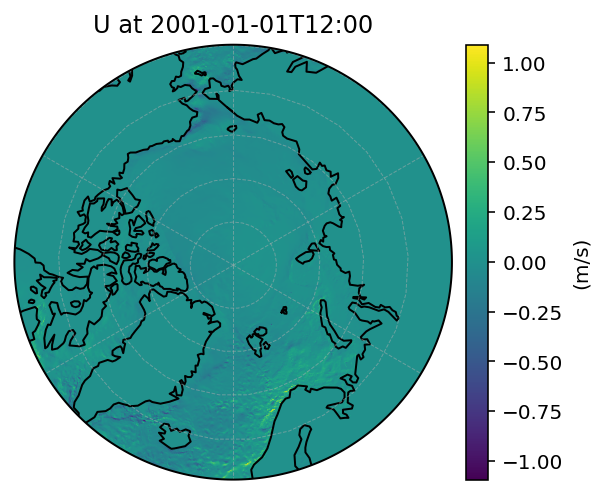

In [7]:
fig, ax = plot.from_field(fieldset.U, polar=True, land=False, latRange=(60,90))
plt.show()

In [4]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMask = community.hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

In [5]:
myParts = community.particles.from_pickle('/scratch/DaanR/meshes/ico_mesh_parts_deg_arctic_r11_delland.pickle')
print("Number of particles:", myParts.n)

Number of particles: 1450665


In [10]:
# myBins.oceanMask_from_particles(myParts, fieldset=fieldset)
# with open("oceanMask_no_rim.pickle", "wb") as pickFile:
#     pickle.dump(myBins.oceanMask, pickFile)

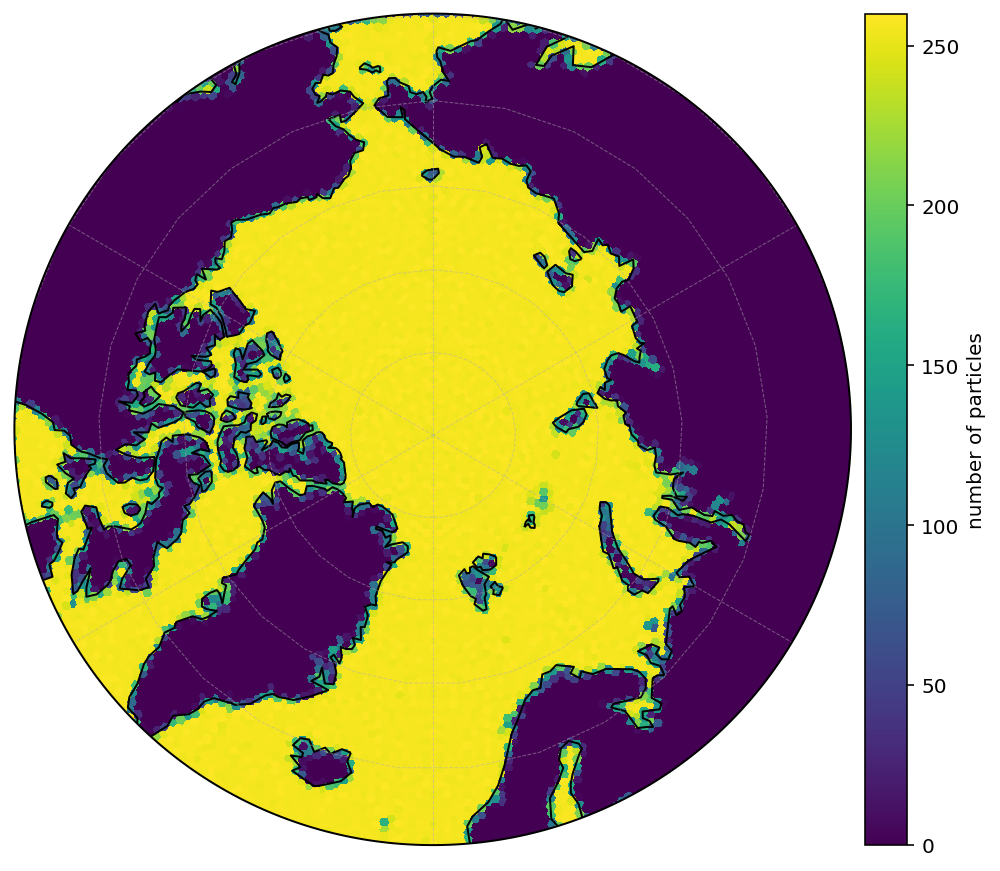

In [20]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.initCount[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             units = "number of particles",
                                             size=(8,8))

## March 2018

In [289]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"

In [ ]:
# transMat_20180301 = community.transMat.from_pset(psetdir + f"pset_{runName}.nc", 
#                                                myBins, 
#                                                timedelta64 = np.timedelta64(30, 'D'),
#                                                mask = myBins.oceanMask)
# transMat_20180301.save_counter(matdir + f"masked_counter_{runName}_Cico7_subD30")
# transMat_20180301.save_network(netdir + f"masked_network_{runName}_Cico7_subD30.net")

In [7]:
transMat_20180301 = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7_subD30.npz")

In [290]:
comName = runName + "_Cico7_subD30_mt2_seed1"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)
print("Codelength: ", myBins.codelength)

communityId1 = myBins.communityID

Global Coherence Ratio 0.8084236252404682
Global Mixing Parameter 0.3224968415601577
Codelength:  6.55602


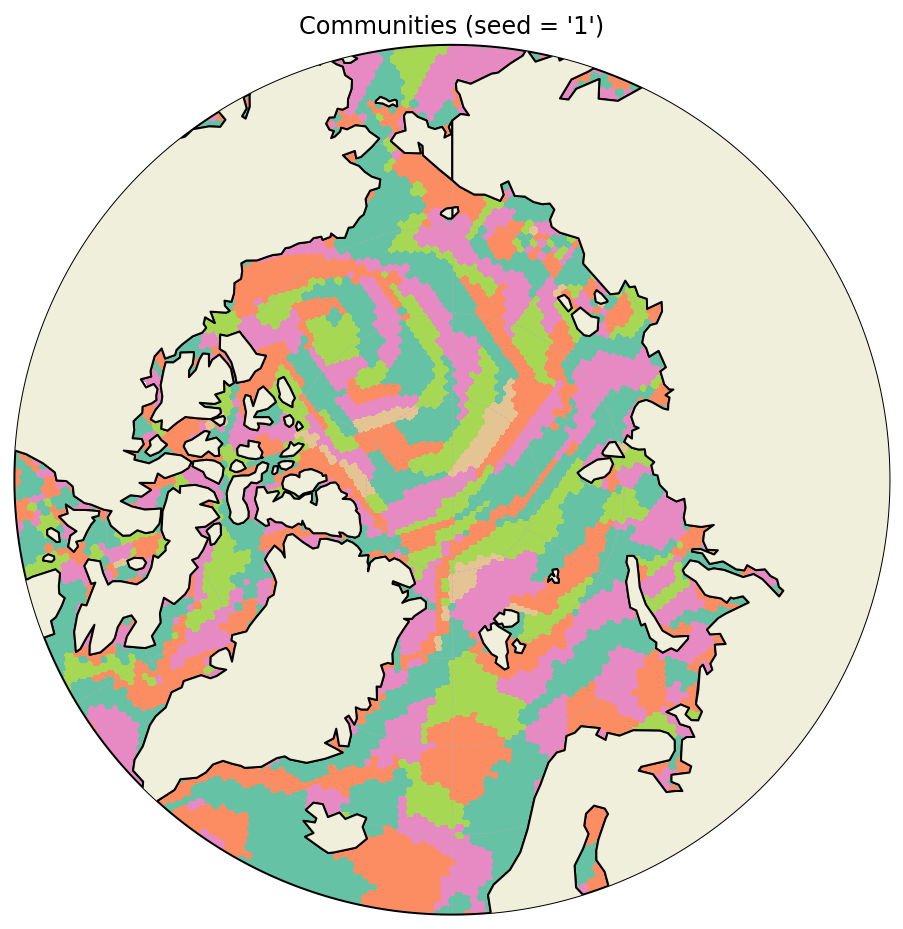

In [14]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (seed = '1')"
                                            )

In [291]:
comName = runName + "_Cico7_subD30_mt2_seed2"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)
print("Codelength: ", myBins.codelength)

communityId2 = myBins.communityID

Global Coherence Ratio 0.8035505639189615
Global Mixing Parameter 0.32619977940611344
Codelength:  6.55636


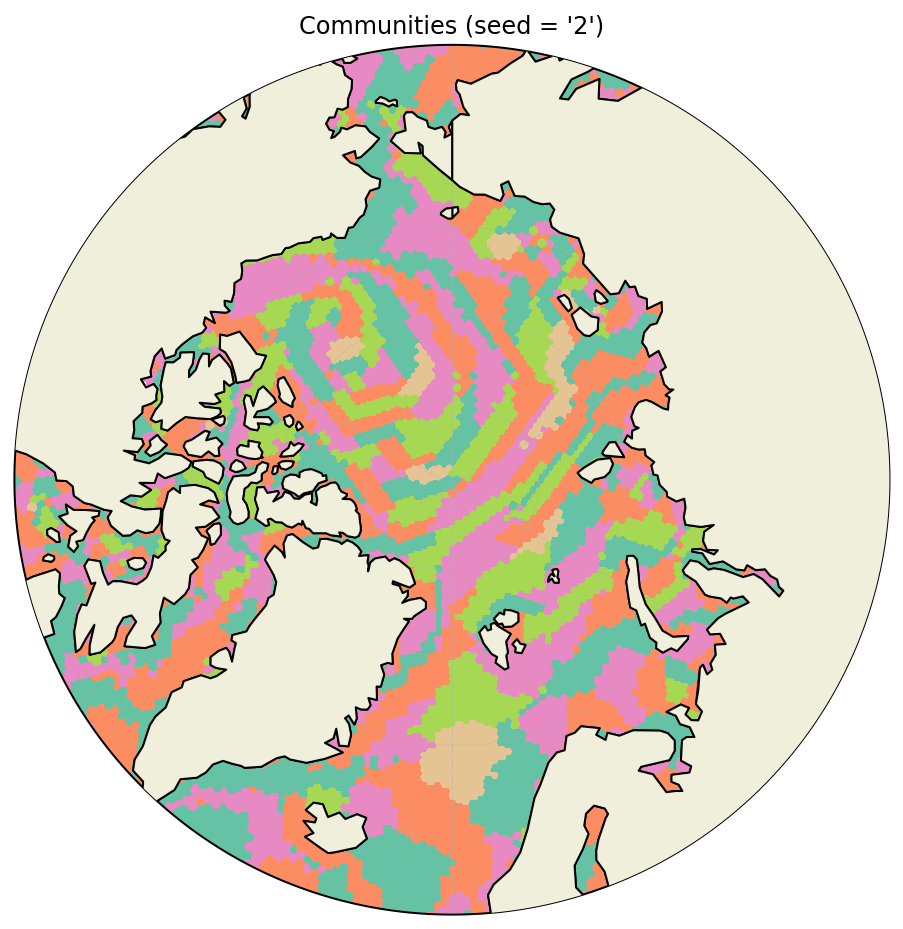

In [16]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (seed = '2')"
                                            )

In [292]:
comName = runName + "_Cico7_subD30_mt2_seed3"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)
print("Codelength: ", myBins.codelength)

communityId3 = myBins.communityID

Global Coherence Ratio 0.8068681809584929
Global Mixing Parameter 0.3240329013885656
Codelength:  6.54959


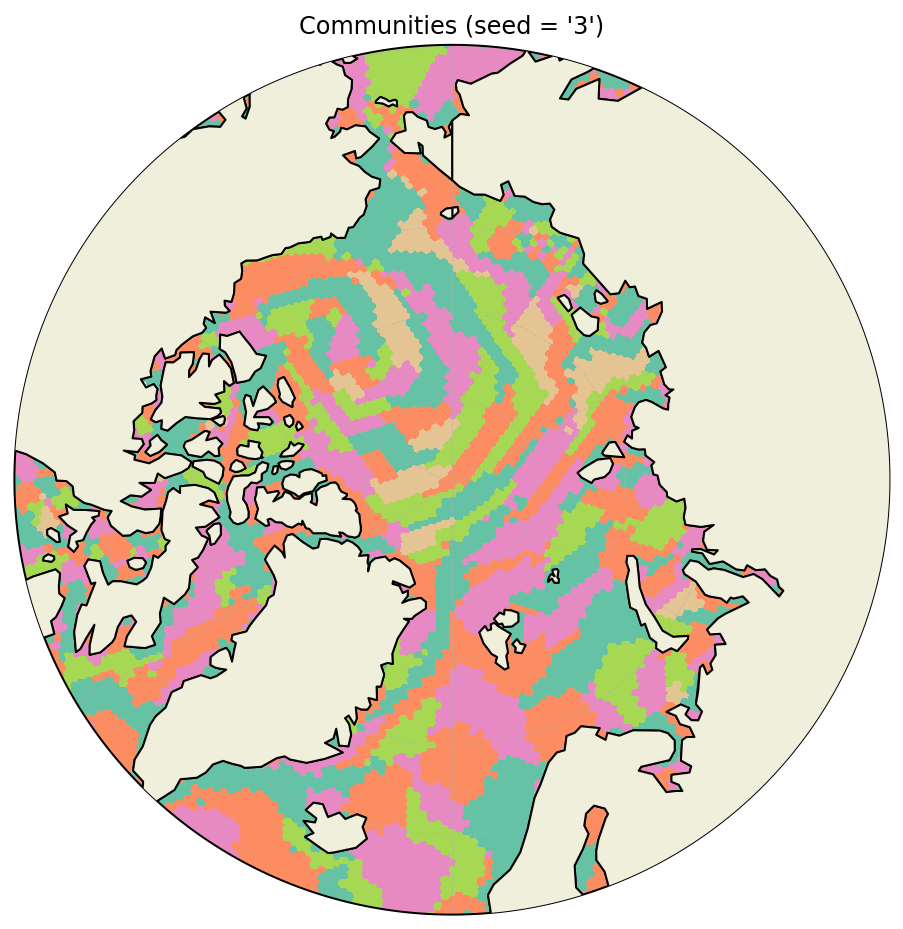

In [18]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (seed = '3')"
                                            )

## NMI

In [263]:
from sklearn.metrics import normalized_mutual_info_score

NMI between two identified communities.

In [257]:
normalized_mutual_info_score(communityId1[myBins.oceanMask], communityId2[myBins.oceanMask], average_method = 'arithmetic')

0.9091201930681398

In [262]:
normalized_mutual_info_score(communityId1[myBins.oceanMask], communityId3[myBins.oceanMask], average_method = 'arithmetic')

0.9059279410043583

Comparing with a result in september

In [287]:
runName = "Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24"
comName = runName + "_Cico7_subD30_mt2_rawdir"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
communityId4 = myBins.communityID
print("Codelength: ", myBins.codelength)

Codelength:  7.91966


In [266]:
normalized_mutual_info_score(communityId1[myBins.oceanMask], communityId4[myBins.oceanMask], average_method = 'arithmetic')

0.7646610481796405

Increasing N

In [293]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"
comName = runName + "_Cico7_subD30_mt2_seed1_N100"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)
print("Codelength: ", myBins.codelength)
communityID_N100_seed1 = myBins.communityID

Global Coherence Ratio 0.8094990175439188
Global Mixing Parameter 0.3246034869469309
Codelength:  6.53691
Codelength:  6.53691


In [294]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"
comName = runName + "_Cico7_subD30_mt2_seed2_N100"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)
print("Codelength: ", myBins.codelength)
communityID_N100_seed2 = myBins.communityID

Global Coherence Ratio 0.8112502502223645
Global Mixing Parameter 0.32400538747049706
Codelength:  6.54494


In [273]:
normalized_mutual_info_score(communityID_N100_seed1[myBins.oceanMask], communityID_N100_seed2[myBins.oceanMask], average_method="arithmetic")

0.9009062580051538

In [296]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"
comName = runName + "_Cico7_subD30_mt2_seed1b_N100"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)
print("Codelength: ", myBins.codelength)
communityID_N100_seed1b = myBins.communityID

Global Coherence Ratio 0.8094990175439188
Global Mixing Parameter 0.3246034869469309
Codelength:  6.53691


In [275]:
normalized_mutual_info_score(communityID_N100_seed1[myBins.oceanMask], communityID_N100_seed1b[myBins.oceanMask], average_method="arithmetic")

1.0

In [299]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"
comName = runName + "_Cico7_subD30_mt2_noseedA_N100"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)
print("Codelength: ", myBins.codelength)
communityID_N100_noseedA = myBins.communityID

Global Coherence Ratio 0.807339267368558
Global Mixing Parameter 0.324783923941253
Codelength:  6.54883


In [300]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"
comName = runName + "_Cico7_subD30_mt2_noseedB_N100"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)
print("Codelength: ", myBins.codelength)
communityID_N100_noseedB = myBins.communityID

Global Coherence Ratio 0.807339267368558
Global Mixing Parameter 0.324783923941253
Codelength:  6.54883


In [278]:
normalized_mutual_info_score(communityID_N100_noseedA, communityID_N100_noseedB)

/science/users/4302001/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


1.0

6.54883